In [ ]:
!pip install fastf1

In [ ]:
import fastf1 as ff1
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

In [ ]:
# We load the session and select the desired data.
session = ff1.get_session(2023, 'Singapore', 'Q')   #Q and R
session.load()

lap = session.laps.pick_fastest()
tel = lap.get_telemetry()
pos = lap.get_pos_data()    # Black line
circuit_info = session.get_circuit_info()

Plotting the track shape and the corners

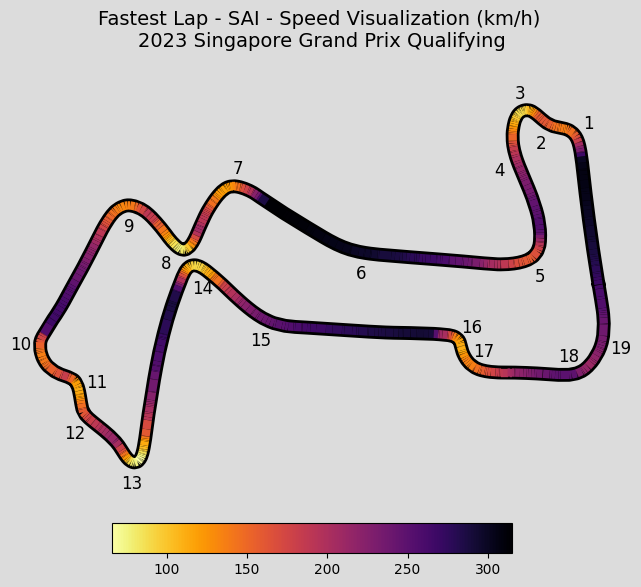

In [ ]:
        # For plotting the SPEED line:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

# Now, we create a set of line segments so that we can color them individually
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
speed = tel['Speed'].to_numpy().astype(float)

# Create a line collection (coloring the shape track). Set a segmented colormap and normalize the plot to integer values of colormap
color = lap.telemetry['Speed']
colormap = mpl.cm.inferno.reversed()

lc = LineCollection(segments, norm=plt.Normalize(color.min(), color.max()), cmap=colormap, linewidth=6)
lc.set_array(speed)

        # For plotting the BLACK line:
# By matrix multiplication of the rotation matrix with a vector [x, y], a new rotated vector [x_rot, y_rot] is obtained.
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

    return np.matmul(xy, rot_mat)

# Get the coordinates: an array of shape [n, 2] where n is the number of points and the second axis is x and y
track = pos.loc[:, ('X', 'Y')].to_numpy()

'''=================================='''

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6), facecolor='gainsboro')
plt.title(f"Fastest Lap - {lap['Driver']} - Speed Visualization (km/h) \n"
          f"{session.event.year} {session.event['EventName']} {session.name}", size=14)

# Add a solid black line around the circuit
plt.plot(track[:, 0], track[:, 1], color='black', linewidth=10)

# Add the LineCollection (speed lines) to the plot
ax.add_collection(lc)

# CORNERS
# 1-Length of the space between number and track
offset_vector = [500, 0]

# 2-Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Finally, PRINT THE CORNER NUMBER.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='large', color='black')

# Axes settings
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.axis('off')

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")

plt.show()